In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import polars as pl # polarsは，pandasより高速に動作するDataFrameライブラリ
import matplotlib.pyplot as plt
from colorama import Fore, Style # 文字に色を付けるライブラリ 
import lightgbm as lgb


In [2]:
from python.metrics import score

In [3]:
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction
DATA_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/data
MODEL_PATH: /home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/model


In [4]:
train = pd.read_csv(DATA_PATH / "train.csv")
train.describe()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
count,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,...,7984.000000,7984.000000,7478.000000,7984.000000,7479.000000,7984.000000,4451.000000,8990.000000,8990.000000,8990.000000
mean,4494.500000,0.031591,0.031591,0.047831,0.575195,0.190656,-0.238042,0.045717,0.142825,0.143159,...,0.489553,0.506930,0.372494,0.287179,0.148270,0.303908,0.129227,0.000469,0.000107,0.000051
std,2595.333794,0.174917,0.174917,0.213420,0.494341,0.392840,0.425909,0.208883,0.349914,0.350254,...,0.306230,0.306554,1.153280,0.312238,1.326879,0.351109,1.277273,0.010551,0.000088,0.010568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000661,0.000661,-2.723527,0.000661,-2.027551,0.000661,-1.497420,-0.039754,-0.000004,-0.040582
25%,2247.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.207011,0.236111,-0.472864,0.000661,-0.797168,0.000661,-0.738242,-0.004324,0.000008,-0.004759
50%,4494.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.492394,0.519180,0.275162,0.180225,-0.097670,0.101025,-0.170825,0.000659,0.000095,0.000252
75%,6741.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.760582,0.772487,1.125069,0.515873,0.795763,0.590030,0.685907,0.005900,0.000193,0.005479
max,8989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,6.809912,1.000000,12.678264,1.000000,12.997536,0.040661,0.000317,0.040551


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10                            7984 non-null   float64
 12  E11                            7984 non-null   f

In [ ]:

score_list_dict = {}

def cross_validate(allocation_model, label='', min_train_size=1500, test_size=120):
    """Print the validation score for allocation_model and the given train–test split.
    
    Parameters:
    allocation_model: object with methods fit and predict
    label: the name of the model
    min_train_size: minimum number of samples for training, taken from the beginning of the training dataset
    test_size: number of samples for testing, taken from the time period immediately after the training
    """
    intermediate_res = []
    # Read the training dataset
    train = pd.read_csv(DATA_PATH / 'train.csv')
    train = train.iloc[1006: ] # 1006行目以降を使用

    oof = np.full(len(train), np.nan)
    score_list = []
    for fold, test_start in enumerate(range(len(train) - test_size, min_train_size, - test_size)):
    
        # Split into train and test
        # test has lagged targets rather than current targets
        test_preliminary = train.iloc[test_start:test_start + test_size].copy()
        solution = test_preliminary[['forward_returns', 'risk_free_rate']].copy()
        lagged = train.iloc[test_start - 1:test_start - 1 + test_size].copy()
        # test = (
        #     test_preliminary
        #     .drop(['forward_returns', 'risk_free_rate', 'market_forward_excess_returns'], axis=1)
        #     .with_columns(
        #         lagged.get_column('forward_returns').alias('lagged_forward_returns'),
        #         lagged.get_column('risk_free_rate').alias('lagged_risk_free_rate'),
        #         lagged.get_column('market_forward_excess_returns').alias('lagged_market_forward_excess_returns'),
        #     )
        # )
        test = test_preliminary.drop(['forward_returns', 'risk_free_rate', 'market_forward_excess_returns'], axis=1)
        # test['lagged_forward_returns'] = lagged['forward_returns'].values
        # test['lagged_risk_free_rate'] = lagged['risk_free_rate'].values
        # test['lagged_market_forward_excess_returns'] = lagged['market_forward_excess_returns'].values
        del test_preliminary

        train1 = train.iloc[:test_start].copy()
        # train1['lagged_forward_returns'] = train1['forward_returns'].shift(1)
        # train1['lagged_risk_free_rate'] = train1['risk_free_rate'].shift(1)
        # train1['lagged_market_forward_excess_returns'] = train1['market_forward_excess_returns'].shift(1)
        # train1 = train1.dropna(subset=['lagged_forward_returns']).reset_index(drop=True)
        
        # display(train1.info)
        # display(train1.describe())
        # return 0
        # print(train1)
        # print(test)
        # print(train1.dtypes)
    
        # === モデル学習 ===
        X_train = train1.drop(['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns'], axis=1)
        y_train = train1['forward_returns']
        X_test = test.drop(['date_id'], axis=1)
        y_test = solution['forward_returns']

        allocation_model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=50)
            ]
        )

        # === 予測 ===
        y_pred = allocation_model.predict(X_test)
        allocation_list = np.clip(y_pred, 0, 2)  # もし必要なら0〜2に制限

        # y_pred内で同一値の割合を出力
        print(f"Fold {fold:2} - Unique predictions ratio: {len(np.unique(y_pred)) / len(y_pred):.4f}")

        # === 評価 ===
        submission = pd.DataFrame({'prediction': allocation_list})
        
        validation_score, intermediate_res = score(solution, submission, '', intermediate_res)
        vol_penalty = intermediate_res[-1][3]
        return_penalty = intermediate_res[-1][4]

        if fold <= 2 or fold >= 59:
            print(f"# Fold {fold:2} train(:{test_start:4}) test({test_start:4}:{test_start+test_size:4}) "
                  f"val_score: {validation_score:6.3f} {vol_penalty=:.2f} {return_penalty=:.2f}")
        if fold == 2:
            print('...')
        oof[test_start:test_start + test_size] = allocation_list
        score_list.append(validation_score)

    # === 全体スコア ===
    print(f"{Fore.RED}# Average validation score: {np.array(score_list).mean():6.3f}", end='   ')
    solution = train[['forward_returns', 'risk_free_rate']]
    submission = pd.DataFrame({'prediction': oof[np.isfinite(oof)]})
    validation_score, intermediate_res = score(solution[np.isfinite(oof)].copy(), submission, '', intermediate_res)
    print(f"Overall validation score: {validation_score:6.3f} {label}{Style.RESET_ALL}")
    score_list_dict[label] = score_list

    # 全ての予測値に対して一致率を出力
    print(f"Overall Unique predictions ratio: {len(np.unique(oof[np.isfinite(oof)])) / len(oof[np.isfinite(oof)]):.4f}")


    vals = oof[np.isfinite(oof)]
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
    if vmin == vmax:
        vmax = vmin + 1e-6  # 同一点回避

    # ビンをデータ範囲に合わせる（50等分）
    bins = np.linspace(vmin, vmax, 50)

    plt.figure(figsize=(6, 2))
    plt.hist(vals, bins=bins, density=False, color='c', edgecolor='k', linewidth=0.5)
    plt.title(f'Allocation histogram of {label}')
    plt.gca().set_yscale('linear')
    plt.gca().get_yaxis().set_visible(False)
    plt.xlim(vmin, vmax)  # 0付近を拡大
    plt.show()

    print(f"Range of predictions: [{vmin:.6f}, {vmax:.6f}]")


In [21]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 50,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
}

[50]	valid_0's rmse: 0.0116244
Fold  0 - Unique predictions ratio: 0.2333
# Fold  0 train(:7864) test(7864:7984) val_score:  0.141 vol_penalty=1.00 return_penalty=6.44
[50]	valid_0's rmse: 0.00900133
Fold  1 - Unique predictions ratio: 0.1417
# Fold  1 train(:7744) test(7744:7864) val_score:  0.300 vol_penalty=1.00 return_penalty=1.00
[50]	valid_0's rmse: 0.00850778
Fold  2 - Unique predictions ratio: 0.5333
# Fold  2 train(:7624) test(7624:7744) val_score:  0.334 vol_penalty=1.00 return_penalty=3.87
...
[50]	valid_0's rmse: 0.00744634
Fold  3 - Unique predictions ratio: 0.0500
[50]	valid_0's rmse: 0.00734797
[100]	valid_0's rmse: 0.0074523
Fold  4 - Unique predictions ratio: 1.0000
[50]	valid_0's rmse: 0.0115668
Fold  5 - Unique predictions ratio: 0.1417
[50]	valid_0's rmse: 0.0161073
Fold  6 - Unique predictions ratio: 1.0000
[50]	valid_0's rmse: 0.0136916
Fold  7 - Unique predictions ratio: 0.9083
[50]	valid_0's rmse: 0.00666182
Fold  8 - Unique predictions ratio: 0.3750
[50]	valid_

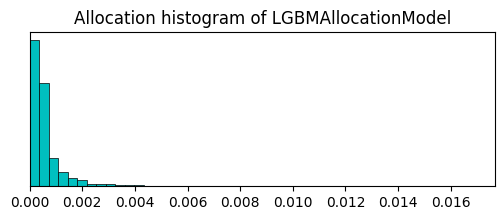

Range of predictions: [0.000000, 0.017675]


In [22]:
model = lgb.LGBMRegressor(**params, n_estimators=1500)
cross_validate(model, label='LGBMAllocationModel')